In [6]:
import os
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import coo_matrix

# -----------------------------
# Config
# -----------------------------
DATASET_DIR = "MachineLearningCVE"
OUTPUT_DIR = "artifacts"
MAX_SAMPLES_PER_CLASS = 50000  # desired per-class samples

def prepare_data(dataset_dir=DATASET_DIR, output_dir=OUTPUT_DIR):
    # -----------------------------
    # 1. Load CSVs
    # -----------------------------
    print("[INFO] Loading CSV files...")
    files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith(".csv")]
    dfs = [pd.read_csv(f, low_memory=False) for f in files]
    df = pd.concat(dfs, ignore_index=True)
    print(f"[INFO] Loaded {len(df)} rows from {len(files)} files")

    # Strip whitespace
    df.columns = df.columns.str.strip()
    df['Label'] = df['Label'].str.strip()

    # -----------------------------
    # 2. Group labels
    # -----------------------------
    mapping = {
        'BENIGN': 'BENIGN',
        'DDoS': 'DDoS',
        'PortScan': 'PortScan',
        'DoS GoldenEye': 'DoS',
        'DoS Hulk': 'DoS',
        'DoS Slowhttptest': 'DoS',
        'DoS slowloris': 'DoS'
    }
    df['Label_grp'] = df['Label'].map(mapping).fillna('Other')
    print("[INFO] Class counts (before undersampling):")
    print(df['Label_grp'].value_counts())

    # -----------------------------
    # 3. Report missing samples
    # -----------------------------
    print("\n[INFO] Samples needed to reach 40k per class:")
    for cls, count in df['Label_grp'].value_counts().items():
        needed = MAX_SAMPLES_PER_CLASS - count
        if needed > 0:
            print(f" - {cls}: need {needed} more samples")
        else:
            print(f" - {cls}: enough samples ({count})")

    # -----------------------------
    # 4. Undersample / limit to MAX_SAMPLES_PER_CLASS
    # -----------------------------
    dfs = []
    for cls, grp in df.groupby('Label_grp'):
        if len(grp) > MAX_SAMPLES_PER_CLASS:
            grp = grp.sample(MAX_SAMPLES_PER_CLASS, random_state=42)
        dfs.append(grp)
    df_bal = pd.concat(dfs, ignore_index=True)
    print("\n[INFO] After undersampling:")
    print(df_bal['Label_grp'].value_counts())
    print(f"[INFO] Total samples: {len(df_bal)}")

    # -----------------------------
    # 5. Features and labels
    # -----------------------------
    y = df_bal["Label_grp"]
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    X = df_bal.drop(columns=["Label", "Label_grp"])
    X = X.select_dtypes(include=[np.number])

    # -----------------------------
    # 6. Clean & Normalize
    # -----------------------------
    # Convert inf/-inf to NaN
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fill NaN with column mean
    X.fillna(X.mean(), inplace=True)

    # Then scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # -----------------------------
    # 7. kNN adjacency graph
    # -----------------------------
    print("[INFO] Building adjacency graph (kNN, k=5)...")
    adj = kneighbors_graph(X_scaled, n_neighbors=5, mode='connectivity', include_self=False)
    adj = coo_matrix(adj)
    row = torch.from_numpy(adj.row).long()
    col = torch.from_numpy(adj.col).long()
    edge_index = torch.stack([row, col], dim=0)

    # -----------------------------
    # 8. Save artifacts
    # -----------------------------
    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, "features.npy"), X_scaled)
    np.save(os.path.join(output_dir, "labels.npy"), y_encoded)
    np.save(os.path.join(output_dir, "edge_index.npy"), edge_index.numpy())
    print(f"[INFO] Saved features, labels, and edge_index -> {output_dir}")
    print(f"[INFO] Final: samples={len(df_bal)} | classes={len(np.unique(y_encoded))}")

if __name__ == "__main__":
    prepare_data()

[INFO] Loading CSV files...
[INFO] Loaded 2830743 rows from 8 files
[INFO] Class counts (before undersampling):
Label_grp
BENIGN      2273097
DoS          252661
PortScan     158930
DDoS         128027
Other         18028
Name: count, dtype: int64

[INFO] Samples needed to reach 40k per class:
 - BENIGN: enough samples (2273097)
 - DoS: enough samples (252661)
 - PortScan: enough samples (158930)
 - DDoS: enough samples (128027)
 - Other: need 31972 more samples

[INFO] After undersampling:
Label_grp
BENIGN      50000
DDoS        50000
DoS         50000
PortScan    50000
Other       18028
Name: count, dtype: int64
[INFO] Total samples: 218028
[INFO] Building adjacency graph (kNN, k=5)...
[INFO] Saved features, labels, and edge_index -> artifacts
[INFO] Final: samples=218028 | classes=5


c:\Users\sivas\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Loading graph data...
[INFO] Using device: cuda
[INFO] Train nodes: 174422 | per-rank: 174422
[INFO] Test nodes:  43606 | classes: 5
[Epoch 0001] loss=1.6642 | acc=0.3289
[Epoch 0005] loss=1.4222 | acc=0.7576
[Epoch 0010] loss=1.1876 | acc=0.7275
[Epoch 0015] loss=0.9942 | acc=0.7431
[Epoch 0020] loss=0.8314 | acc=0.7830
[Epoch 0025] loss=0.7016 | acc=0.8431
[Epoch 0030] loss=0.5957 | acc=0.8444
[Epoch 0035] loss=0.5155 | acc=0.8539
[Epoch 0040] loss=0.4583 | acc=0.8769
[Epoch 0045] loss=0.4172 | acc=0.8928
[Epoch 0050] loss=0.3808 | acc=0.9025
[Epoch 0055] loss=0.3581 | acc=0.9076
[Epoch 0060] loss=0.3347 | acc=0.9118
[Epoch 0065] loss=0.3160 | acc=0.9151
[Epoch 0070] loss=0.3019 | acc=0.9183
[Epoch 0075] loss=0.2856 | acc=0.9209
[Epoch 0080] loss=0.2727 | acc=0.9256
[Epoch 0085] loss=0.2611 | acc=0.9307
[Epoch 0090] loss=0.2502 | acc=0.9363
[Epoch 0095] loss=0.2436 | acc=0.9458
[Epoch 0100] loss=0.2355 | acc=0.9464
[Epoch 0105] loss=0.2273 | acc=0.9484
[Epoch 0110] loss=0.2192

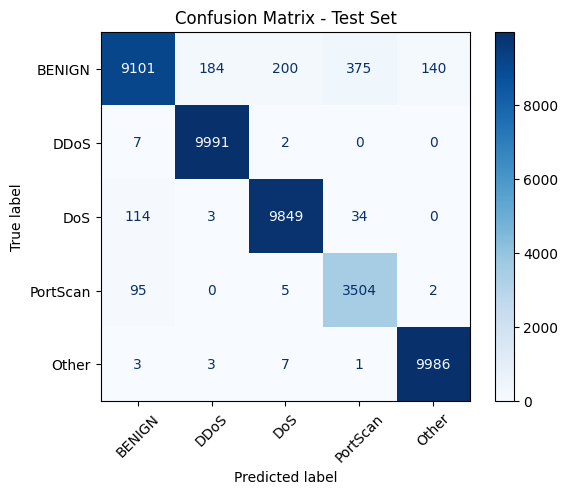

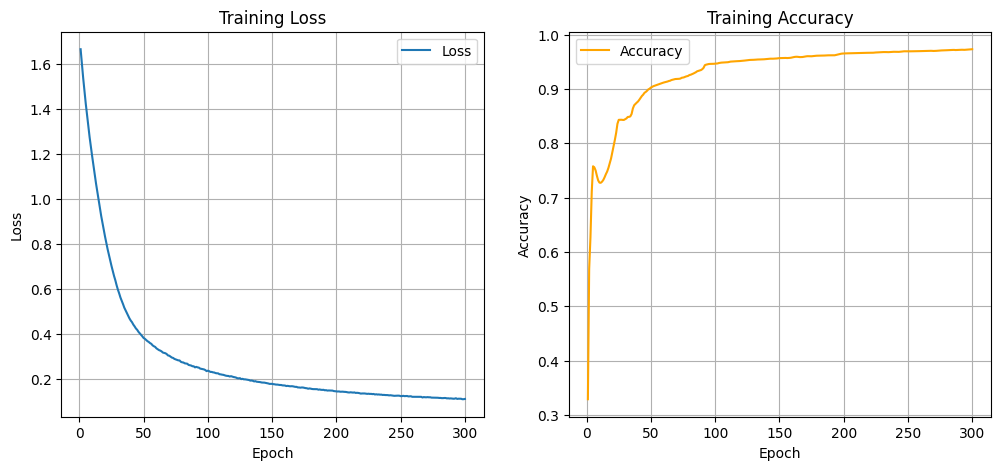

In [1]:
# hpc_gcn_distributed_full_updated.py
import argparse
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from mpi4py import MPI
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import os
import random
from time import time
import matplotlib.pyplot as plt

# PyTorch Geometric
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# --------------------
# Utils
# --------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --------------------
# Define the GCN
# --------------------
class HPCGCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.3):
        super(HPCGCN, self).__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, hid_dim)
        self.fc = nn.Linear(hid_dim, out_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        return self.fc(x)

# --------------------
# Visualization Functions
# --------------------
def visualize_results(true_test, preds_test, train_losses, train_accs, class_names):
    # Confusion Matrix
    cm = confusion_matrix(true_test, preds_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    # Training Curves
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label="Accuracy", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy")
    plt.grid(True)
    plt.legend()

    plt.show()

# --------------------
# Training function
# --------------------
def train_model(data, args, rank, size, comm):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if rank == 0:
        print(f"[INFO] Using device: {device}")

    X = data.x.to(device)
    y = data.y.to(device)
    edge_index = data.edge_index.to(device)

    # Split train/test indices (stratified)
    idx = np.arange(y.shape[0])
    train_idx, test_idx, y_train, y_test = train_test_split(
        idx, y.cpu().numpy(), test_size=0.2, random_state=42, stratify=y.cpu().numpy()
    )

    train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
    test_idx  = torch.tensor(test_idx, dtype=torch.long, device=device)

    in_dim  = X.shape[1]
    out_dim = int(y.max().item() + 1)

    model = HPCGCN(in_dim, args.hid, out_dim, dropout=args.dropout).to(device)

    # ---------------- Weighted Loss for Imbalanced Classes ----------------
    class_counts = Counter(y[train_idx].cpu().numpy())
    weights = torch.tensor([1.0 / class_counts.get(i, 1) for i in range(out_dim)], dtype=torch.float32, device=device)
    criterion = nn.CrossEntropyLoss(weight=weights)

    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    # Partition training nodes across MPI ranks
    n_train = train_idx.shape[0]
    chunk_size = n_train // size
    start = rank * chunk_size
    end = n_train if rank == size - 1 else (rank + 1) * chunk_size
    local_train_idx = train_idx[start:end]

    if rank == 0:
        print(f"[INFO] Train nodes: {n_train} | per-rank: {len(local_train_idx)}")
        print(f"[INFO] Test nodes:  {len(test_idx)} | classes: {out_dim}")

    # Track training curves
    train_losses = []
    train_accs = []

    for epoch in range(1, args.epochs + 1):
        model.train()
        optimizer.zero_grad()

        out = model(X, edge_index)
        loss_local = criterion(out[local_train_idx], y[local_train_idx])
        loss_local.backward()

        # -------- Gradient averaging across ranks --------
        for param in model.parameters():
            if param.grad is None:
                continue
            grad_cpu = param.grad.detach().cpu().numpy().astype(np.float32, copy=True)
            comm.Allreduce(MPI.IN_PLACE, grad_cpu, op=MPI.SUM)
            grad_cpu /= float(size)
            param.grad.data.copy_(torch.from_numpy(grad_cpu).to(param.grad.device))
        # -------------------------------------------------

        optimizer.step()

        # Compute global loss (average across ranks)
        loss_global = np.array([loss_local.item()], dtype=np.float64)
        comm.Allreduce(MPI.IN_PLACE, loss_global, op=MPI.SUM)
        loss_global = float(loss_global[0] / size)

        # Eval on test set
        model.eval()
        with torch.no_grad():
            logits = model(X, edge_index)
            preds = logits[test_idx].argmax(dim=1)
            correct = (preds == y[test_idx]).sum().item()
            acc = correct / len(test_idx)

        # Save curves (only on rank 0)
        if rank == 0:
            train_losses.append(loss_global)
            train_accs.append(acc)
            if epoch % args.log_every == 0 or epoch == 1 or epoch == args.epochs:
                print(f"[Epoch {epoch:04d}] loss={loss_global:.4f} | acc={acc:.4f}")

    # ---------------- Save model & visualize ----------------
    if rank == 0:
        os.makedirs("models", exist_ok=True)
        torch.save(model.state_dict(), "models/hpc_gcn_model.pth")
        print("[INFO] Model saved -> models/hpc_gcn_model.pth")

        # Classes (adjust according to your dataset)
        class_names = ['BENIGN', 'DDoS', 'DoS', 'PortScan', 'Other']
        print(f"\nClasses ({len(class_names)}): {class_names}")

        # Evaluate on test set
        preds_test = logits[test_idx].argmax(dim=1).cpu().numpy()
        true_test = y[test_idx].cpu().numpy()
        print("\n=== Test Set Classification Report ===")
        from sklearn.metrics import classification_report
        print(classification_report(true_test, preds_test, target_names=class_names, digits=4))

        # Visualize confusion matrix & training curves
        visualize_results(true_test, preds_test, train_losses, train_accs, class_names)

# --------------------
# Main
# --------------------
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_dir", type=str, default="artifacts")
    parser.add_argument("--epochs", type=int, default=300)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--hid", type=int, default=128)
    parser.add_argument("--dropout", type=float, default=0.3)
    parser.add_argument("--weight_decay", type=float, default=5e-4)
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--log_every", type=int, default=5)

    args, _ = parser.parse_known_args()  # ignore unknown args for Jupyter safety

    set_seed(args.seed)

    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    if rank == 0:
        print("[INFO] Loading graph data...")

    # Load preprocessed artifacts
    features = np.load(os.path.join(args.data_dir, "features.npy"))
    labels   = np.load(os.path.join(args.data_dir, "labels.npy"))
    edge_idx = np.load(os.path.join(args.data_dir, "edge_index.npy"))

    X = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.long)
    edge_index = torch.tensor(edge_idx, dtype=torch.long)

    data = Data(x=X, y=y, edge_index=edge_index)

    train_model(data, args, rank, size, comm)

if __name__ == "__main__":
    main()
